## Instruction of using this notebook

We wrote the code returning strategy return in the AIP.py file. With the import function `from AIP import AIP`, we can use the AIP to calculate returns with different parameters. 

our paramters include:
* input_file: the input dataset, the default is 'SPY.csv'(S&P 500 ETF)
* start_date: we will start investing from start_date
* time_length: the number of years to do the investment.
* ma_period: how many days used to calculate the moving average
* inv_period: the time interval we repeat the investment 
* function: the function we used to adjust amount to invest.
* min_rate: minimum percentage we want to invest. 
* max_rate: maximum percentage we want to invest. 

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import datetime
import math
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

The class `AIP` is the model we used to optimize our strategy. 
The method `fit` could generate the return after we input our strategy as well as the time we want to start investing.

In [2]:
class AIP(object):
    def __init__(self,input_file,start_date,inv_period,time_length,
                 ma_period, function,min_rate,max_rate
                 ):
        """
        :param input_file: the SPY data file name
        :param start_date: the date you want to start do the AIP, the format must be like:
            'YYYY-MM-dd', eg. "2000-01-01"
        :param inv_period: {'weekly','monthly',int}the frequency of investment you want. If you
        type an int, you would investment in that fixed period
        :param time_length: int. How many years you would do the AIP?
        :param ma_period: int. How many days you may consider the moving average backward?
        :param function: {'linear','log','exp','ali','null'},'linear' default,'ali' is the method alipay use
        :param min_rate:the minimum percentage you would invest
        :param max_rate:the maximum percentage you would invest
        """
        self.AIP_data = pd.read_csv(input_file,index_col=0,parse_dates=[0])
        self.start_date = start_date
        self.inv_period = inv_period
        self.time_length = time_length
        self.ma_period = ma_period
        self.function = function
        self.min_rate = min_rate
        self.max_rate = max_rate

    def moving_avg(self, last_day, period=100):
        """
        last_day: the format must be "YYYY-MM-DD",e.g '2020-01-01'
        period: gives the length of days you want to calculate, if the backward day is not the trade day.
        will calculate from the trade day after the backward day.
        """
        last_day_dt = date(int(last_day[:4]), int(last_day[5:7]), int(last_day[8:10]))
        first_day_dt = last_day_dt - datetime.timedelta(days=period)
        first_day = str(first_day_dt)
        data_cal = self.AIP_data.loc[first_day:last_day, 'Adj Close']
        return data_cal.mean()

    def adjust_rate(self,price, ma_price, function='linear', min_rate=0.5, max_rate=1.5):
        """
        min_rate: the minimum rate you should invest
        function:{'linear','log','exp','ali','null'},'linear' default,'ali' is the method alipay use
        """
        percent = -(price - ma_price) / ma_price
        ali_percent = -percent
        rate = min(max(min_rate, 1 + percent), min(1 + percent, max_rate))
        if function == 'linear':
            return rate
        elif function == 'null':
            return 1
        elif function == 'log':
            return max(math.log(rate) + 1, 0)
        elif function == 'exp':
            return math.exp(rate - 1)
        elif function == 'ali':
            if ali_percent > 1:
                return 0.6
            elif ali_percent >= 0.5:
                return 0.7
            elif ali_percent >= 0.15:
                return 0.8
            elif ali_percent > 0:
                return 0.9
            else:
                return 1
        else:
            return "error!!!, check your function parameter"

    def next_trade_day(self,date):
        data = self.AIP_data
        next_date = str(data.loc[date:,].head(1).index[0])
        return next_date

    def daymove(self,start, move='monthly'):
        """
        move: {'monthly','weekly',int}choose the time period you want to automatic invest. If you type in an integer,
        you would invest it for each that period.
        """
        dt = date(int(start[:4]), int(start[5:7]), int(start[8:10]))
        if move == 'monthly':
            return str(dt + relativedelta(months=1))
        elif move == 'weekly':
            return str(dt + datetime.timedelta(days=7))
        elif type(move) == type(1):
            return str(dt + datetime.timedelta(days=move))
        else:
            return "error! check the move variable!!!"

    def get_end_days(self,start, move=3):
        """
        move: the number of year you want to test
        """
        dt = date(int(start[:4]), int(start[5:7]), int(start[8:10]))
        return str(dt + relativedelta(years=move))

    def fit(self):
        money = 1000
        AIP_data = self.AIP_data
        AIP_data['money'] = 0
        AIP_data['quantity'] = 0
        start_date = self.start_date
        time_length = self.time_length
        ma_period = self.ma_period
        inv_period = self.inv_period
        function = self.function
        min_rate = self.min_rate
        max_rate = self.max_rate
        end_date = self.get_end_days(start_date,time_length) # the date to stop calculate
        next_trade_date = self.next_trade_day(start_date)
        next_date = start_date
        while next_trade_date <= end_date:
            ma_price = self.moving_avg(next_trade_date, ma_period)
            AIP_data.loc[next_trade_date, 'money'] = money * self.adjust_rate(ma_price,
                                                                         AIP_data.loc[next_trade_date, 'Adj Close'],
                                                                         function,min_rate, max_rate)
            next_date = self.daymove(next_date, inv_period)
            next_trade_date = self.next_trade_day(next_date)
        end_cal_date = self.daymove(next_trade_date,inv_period)
        data_used = AIP_data.loc[start_date:end_cal_date, :]
        data_used['quantity'] = data_used['money'] / data_used['Adj Close']
        total_quant = data_used['quantity'].sum()
        ret = (total_quant * data_used.tail(1)['Adj Close'].values[0]) / data_used['money'].sum() - 1
        return ret

## 15 combinations of start_date and time_length

Due to our limited computing capacity and ensure a fair comparision, we decide to choose 3 investment period - 3, 5, 10 years, and five start_date 1995-01-01, 2000-01-01, 2005-01-01, 2010-01-01, 2015-01-01. Thus, they form 15 unique combinations, and we will explore the rest of the paramters for each of these 15 combinations. 

For this strategy, we decide to start investing at the beginning of the year. 

In [6]:
start_date_list = ['1995-01-01','2000-01-01','2005-01-01','2010-01-01','2015-01-01']
time_length_list = [3,5,10]
print('start_date: ', start_date_list)
print('time_length: ',time_length_list)

start_date:  ['1995-01-01', '2000-01-01', '2005-01-01', '2010-01-01', '2015-01-01']
time_length:  [3, 5, 10]


## Benchmark

For each of the 15 combinations, we will calculate a benchmark return, which is the return of investing a fixed amount monthly. Parameters including `ma_period`, `min_rate`, `max_rate` are not useful in this baseline model. Only parameters we will use are: 

- `inv_period = 'monthly`
- `function = 'null'`


In [7]:
bench_ret = pd.DataFrame(columns=['start_date', 'time_length','benchmark_return'])

input_file = 'SPY.csv'
inv_period = 'monthly'
function = 'null'

# random chosen number but not affect the result
ma_period = 500
min_rate = 1
max_rate = 1


for start_date in start_date_list:
    for time_length in time_length_list:
        if start_date == '2015-01-01' and time_length==10:
            continue
        aip = AIP(input_file, start_date, inv_period, time_length, ma_period, function, min_rate, max_rate)
        aip_ret = aip.fit()
        bench_ret = bench_ret.append({'start_date': start_date,
                                      'time_length': time_length,
                                      'benchmark_return': aip_ret},ignore_index=True)

<ipython-input-5-98a8ea8a52f1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['quantity'] = data_used['money'] / data_used['Adj Close']


In [4]:
bench_ret

,start_date,time_length,benchmark_return
0,1995-01-01,3,0.565426
1,1995-01-01,5,0.870118
2,1995-01-01,10,0.389874
3,2000-01-01,3,-0.258272
4,2000-01-01,5,0.106651
5,2000-01-01,10,0.016329
6,2005-01-01,3,0.090386
7,2005-01-01,5,-0.062496
8,2005-01-01,10,0.742607
9,2010-01-01,3,0.255012


## Grid Search

In this step, we are going to do grid search on the rest paramters for each combination, and see if any paramter combination can overperform the benchmark. 

The paramters explored in our grid search including: 
- `ma_period: [28, 50, 100, 200, 500, 800, 1200]`
- `inv_period: ['weekly','monthly']`
- `function：['linear','log','exp','ali','null']`
- `min_rate: np.arange(0.5,0.9,0.1)`
- `max_rate: np.arange(1.5,2.3,0.1)`

In [5]:
from datetime import datetime

input_file = 'SPY.csv'
start_date_list = ['1995-01-01','2000-01-01','2005-01-01','2010-01-01','2015-01-01']
time_length_list = [3,5,10]

# grid search paramters
ma_period_list = [28, 50, 100, 200, 500, 800, 1200]
inv_period_list = ['weekly','monthly']
function_list = ['linear','log','exp','ali','null']
min_rate_list = list(np.arange(0.5,0.9,0.1))
max_rate_list = list(np.arange(1.5,2.3,0.1))

In [6]:
# grid search -> takes few hours
# export the result to a csv so that have quicker acccess for each run

# df = {}
# for start_date in start_date_list:
#     for time_length in time_length_list:
        
#         input_file = 'SPY.csv'
#         year = datetime.strptime(start_date, '%Y-%m-%d').year
#         df[f"{year}_{time_length}"] = pd.DataFrame(columns=['start_date','time_length',
#                                           'inv_period','ma_period',
#                                           'function','min_rate',
#                                           'max_rate','return'])
       
#         for ma_period in ma_period_list:
#             for inv_period in inv_period_list:
#                 for function in function_list: 
#                     for min_rate in min_rate_list:
#                         for max_rate in max_rate_list:
#                                 aip = AIP(input_file,start_date,inv_period,time_length,
#                                           ma_period, function,min_rate,max_rate)
#                                 aip_ret = aip.fit()
#                                 df[f"{year}_{time_length}"]=df[f"{year}_{time_length}"].append({
#                                                             "start_date":start_date,
#                                                             "time_length":time_length,
#                                                             "inv_period":inv_period,
#                                                             "ma_period":ma_period,
#                                                             "function":function,
#                                                             "min_rate":min_rate,
#                                                             "max_rate":max_rate,
#                                                             "return":aip_ret},ignore_index=True)
                                
#         df[f"{year}_{time_length}"].to_csv(f"{year}_{time_length}.csv")

In [7]:
# read file from the grid search result
# df_1995_3 = pd.read_csv('df_1995_3.csv', index_col=[0], parse_dates=[1])
# df_1995_5 = pd.read_csv('df_1995_5.csv', index_col=[0], parse_dates=[1])
# df_1995_10 = pd.read_csv('df_1995_10.csv', index_col=[0], parse_dates=[1])

# df_2000_3 = pd.read_csv('df_2000_3.csv', index_col=[0], parse_dates=[1])
# df_2000_5 = pd.read_csv('df_2000_5.csv', index_col=[0], parse_dates=[1])
# df_2000_10 = pd.read_csv('df_2000_10.csv', index_col=[0], parse_dates=[1])

# df_2005_3 = pd.read_csv('df_2005_3.csv', index_col=[0], parse_dates=[1])
# df_2005_5 = pd.read_csv('df_2005_5.csv', index_col=[0], parse_dates=[1])
# df_2005_10 = pd.read_csv('df_2005_10.csv', index_col=[0], parse_dates=[1])

# df_2010_3 = pd.read_csv('df_2010_3.csv', index_col=[0], parse_dates=[1])
# df_2010_5 = pd.read_csv('df_2010_5.csv', index_col=[0], parse_dates=[1])
# df_2010_10 = pd.read_csv('df_2010_10.csv', index_col=[0], parse_dates=[1])

# df_2015_3 = pd.read_csv('df_2015_3.csv', index_col=[0], parse_dates=[1])
# df_2015_5 = pd.read_csv('df_2015_5.csv', index_col=[0], parse_dates=[1])

In [8]:
# three_year_inv = df_1995_3.append(df_2000_3).append(df_2005_3).append(df_2010_3).append(df_2015_3)
# five_year_inv = df_1995_5.append(df_2000_5).append(df_2005_5).append(df_2010_5).append(df_2015_5)
# ten_year_inv = df_1995_10.append(df_2000_10).append(df_2005_10).append(df_2010_10)

In [9]:
# full_data = three_year_inv.append(five_year_inv).append(ten_year_inv)
full_data = pd.read_csv('full_data.csv', index_col=[0], parse_dates=[1])

## Explore different parameters

In [10]:
full_data.head()

,start_date,time_length,inv_period,ma_period,function,min_rate,max_rate,return
0,1995-01-01,3,weekly,28,linear,0.5,1.5,0.457111
1,1995-01-01,3,weekly,28,linear,0.5,1.6,0.457111
2,1995-01-01,3,weekly,28,linear,0.5,1.7,0.457111
3,1995-01-01,3,weekly,28,linear,0.5,1.8,0.457111
4,1995-01-01,3,weekly,28,linear,0.5,1.9,0.457111


### Top Returns

For each of the 15 combination of start_date and time_lenth

In [17]:
top_returns = full_data.groupby(['start_date','time_length']).agg({'return':'max'})
top_returns

return
start_date time_length          
1995-01-01 3            0.568799
           5            0.897867
           10           0.403306
2000-01-01 3           -0.190389
           5            0.110515
           10           0.098650
2005-01-01 3            0.102024
           5            0.013128
           10           0.747447
2010-01-01 3            0.255012
           5            0.526863
           10           1.064130
2015-01-01 3            0.308606
           5            0.437950

### Average returns

In [22]:
grid_describe = full_data.groupby(['start_date','time_length'])['return'].describe().round(4).drop(columns='count').reset_index()
grid_describe['sharpe'] = grid_describe['mean']/grid_describe['std']

grid_describe.to_excel('plot.xlsx')


### Investment Period

In [13]:
full_data.groupby(['time_length','inv_period'])['return'].describe().drop(columns='count')

count      mean       std       min       25%  \
time_length inv_period                                                   
3           monthly     5600.0  0.188931  0.273045 -0.287865  0.089501   
            weekly      5600.0  0.175273  0.219667 -0.225209  0.100985   
5           monthly     5600.0  0.364646  0.328490 -0.106172  0.094621   
            weekly      5600.0  0.389909  0.316667 -0.034306  0.098326   
10          monthly     4480.0  0.541563  0.384287 -0.025768  0.296488   
            weekly      4480.0  0.565573  0.363050  0.052925  0.312583   

                             50%       75%       max  
time_length inv_period                                
3           monthly     0.253396  0.308125  0.568799  
            weekly      0.215371  0.306735  0.459428  
5           monthly     0.419820  0.515523  0.879224  
            weekly      0.436065  0.525496  0.897867  
10          monthly     0.537470  0.811262  1.048547  
            weekly      0.536640  0.819057  1.064130

### Moving Average

In [14]:
full_data.groupby(['time_length','ma_period'])['return'].describe().round(4).drop(columns='count')

count    mean     std     min     25%     50%     75%  \
time_length ma_period                                                           
3           28         1600.0  0.1849  0.2470 -0.2602  0.0903  0.2350  0.3079   
            50         1600.0  0.1847  0.2470 -0.2601  0.0903  0.2346  0.3074   
            100        1600.0  0.1841  0.2471 -0.2614  0.0901  0.2346  0.3067   
            200        1600.0  0.1831  0.2476 -0.2650  0.0900  0.2341  0.3062   
            500        1600.0  0.1814  0.2483 -0.2722  0.0891  0.2354  0.3063   
            800        1600.0  0.1794  0.2492 -0.2815  0.0895  0.2334  0.3073   
            1200       1600.0  0.1771  0.2493 -0.2879  0.0895  0.2298  0.3074   
5           28         1600.0  0.3828  0.3210 -0.0641  0.1061  0.4286  0.5255   
            50         1600.0  0.3825  0.3212 -0.0647  0.1057  0.4287  0.5247   
            100        1600.0  0.3817  0.3214 -0.0671  0.1048  0.4287  0.5234   
            200        1600.0  0.3802  0.3225 -0.0742  0.1028  0.4283  0.5216   
            500        1600.0  0.3759  0.3252 -0.0964  0.0954  0.4274  0.5224   
            800        1600.0  0.3714  0.3256 -0.1062  0.0858  0.4272  0.5168   
            1200       1600.0  0.3664  0.3233 -0.1061  0.0745  0.4280  0.5168   
10          28         1280.0  0.5598  0.3741  0.0143  0.3126  0.5672  0.8213   
            50         1280.0  0.5594  0.3739  0.0146  0.3126  0.5666  0.8212   
            100        1280.0  0.5585  0.3735  0.0129  0.3126  0.5640  0.8210   
            200        1280.0  0.5567  0.3733  0.0084  0.3126  0.5602  0.8204   
            500        1280.0  0.5525  0.3758 -0.0063  0.3126  0.5473  0.8216   
            800        1280.0  0.5473  0.3754 -0.0174  0.3126  0.5396  0.8205   
            1200       1280.0  0.5408  0.3724 -0.0258  0.3126  0.5351  0.8149   

                          max  
time_length ma_period          
3           28         0.5688  
            50         0.5680  
            100        0.5654  
            200        0.5654  
            500        0.5654  
            800        0.5654  
            1200       0.5654  
5           28         0.8974  
            50         0.8979  
            100        0.8956  
            200        0.8944  
            500        0.8918  
            800        0.8914  
            1200       0.8914  
10          28         1.0604  
            50         1.0604  
            100        1.0604  
            200        1.0604  
            500        1.0641  
            800        1.0604  
            1200       1.0604

### Function

In [28]:
full_data=full_data.fillna('null')
full_data.groupby(['time_length','function'])['return'].describe().round(4).drop(columns='count')

mean     std     min     25%     50%     75%     max
time_length function                                                        
3           ali       0.1836  0.2485 -0.2683  0.0904  0.2334  0.3069  0.5688
            exp       0.1805  0.2475 -0.2821  0.0899  0.2297  0.3067  0.5649
            linear    0.1806  0.2481 -0.2841  0.0899  0.2300  0.3067  0.5649
            log       0.1805  0.2488 -0.2879  0.0900  0.2303  0.3067  0.5650
            null      0.1854  0.2467 -0.2583  0.0904  0.2358  0.3086  0.5654
5           ali       0.3802  0.3237 -0.0772  0.0985  0.4286  0.5235  0.8979
            exp       0.3748  0.3220 -0.0906  0.0907  0.4270  0.5220  0.8924
            linear    0.3745  0.3234 -0.0967  0.0888  0.4272  0.5222  0.8926
            log       0.3736  0.3253 -0.1062  0.0858  0.4273  0.5224  0.8927
            null      0.3832  0.3202 -0.0625  0.1067  0.4297  0.5269  0.8914
10          ali       0.5560  0.3737  0.0017  0.3160  0.5579  0.8172  1.0597
            exp       0.5520  0.3736 -0.0147  0.3131  0.5452  0.8131  1.0641
            linear    0.5508  0.3740 -0.0189  0.3131  0.5423  0.8134  1.0637
            log       0.5487  0.3745 -0.0258  0.3131  0.5372  0.8136  1.0633
            null      0.5604  0.3745  0.0163  0.3126  0.5662  0.8216  1.0604

### Rates

In [35]:
full_data.groupby(['time_length','min_rate'])['return'].describe()

count      mean       std       min       25%  \
time_length min_rate                                                   
3           0.5       2800.0  0.182102  0.247914 -0.287865  0.090261   
            0.6       2800.0  0.182102  0.247914 -0.287865  0.090261   
            0.7       2800.0  0.182102  0.247914 -0.287865  0.090261   
            0.8       2800.0  0.182102  0.247914 -0.287865  0.090261   
5           0.5       2800.0  0.377277  0.322909 -0.106172  0.097031   
            0.6       2800.0  0.377277  0.322909 -0.106172  0.097031   
            0.7       2800.0  0.377277  0.322909 -0.106172  0.097031   
            0.8       2240.0  0.364613  0.359903 -0.106172  0.055572   
            0.8        560.0  0.427935  0.008293  0.416979  0.419820   
10          0.5       2240.0  0.553568  0.374054 -0.025768  0.312583   
            0.6       2240.0  0.553568  0.374054 -0.025768  0.312583   
            0.7       2240.0  0.553568  0.374054 -0.025768  0.312583   
            0.8       1680.0  0.722270  0.268452  0.383894  0.396641   
            0.8        560.0  0.047462  0.042692 -0.025768  0.013277   

                           50%       75%       max  
time_length min_rate                                
3           0.5       0.229760  0.307263  0.568799  
            0.6       0.229760  0.307263  0.568799  
            0.7       0.229760  0.307263  0.568799  
            0.8       0.229760  0.307263  0.568799  
5           0.5       0.427224  0.523467  0.897867  
            0.6       0.427224  0.523467  0.897867  
            0.7       0.427224  0.523467  0.897867  
            0.8       0.300016  0.602992  0.897867  
            0.8       0.427224  0.436065  0.437950  
10          0.5       0.537470  0.814892  1.064130  
            0.6       0.537470  0.814892  1.064130  
            0.7       0.537470  0.814892  1.064130  
            0.8       0.735548  1.042132  1.064130  
            0.8       0.034627  0.095308  0.098650

In [36]:
full_data.groupby(['time_length','max_rate'])['return'].describe()

count      mean       std       min       25%  \
time_length max_rate                                                   
3           1.5       1400.0  0.182102  0.247958 -0.287865  0.090261   
            1.6       1400.0  0.182102  0.247958 -0.287865  0.090261   
            1.7       1400.0  0.182102  0.247958 -0.287865  0.090261   
            1.8       1400.0  0.182102  0.247958 -0.287865  0.090261   
            1.9       1400.0  0.182102  0.247958 -0.287865  0.090261   
            2.0       1400.0  0.182102  0.247958 -0.287865  0.090261   
            2.1       1400.0  0.182102  0.247958 -0.287865  0.090261   
            2.2       1400.0  0.182102  0.247958 -0.287865  0.090261   
5           1.5       1400.0  0.377277  0.322967 -0.106172  0.097031   
            1.6       1400.0  0.377277  0.322967 -0.106172  0.097031   
            1.7        280.0  0.427935  0.008300  0.416979  0.419820   
            1.7       1120.0  0.364613  0.359983 -0.106172  0.055572   
            1.8        280.0  0.427935  0.008300  0.416979  0.419820   
            1.8       1120.0  0.364613  0.359983 -0.106172  0.055572   
            1.9        280.0  0.427935  0.008300  0.416979  0.419820   
            1.9       1120.0  0.364613  0.359983 -0.106172  0.055572   
            2.0        280.0  0.427935  0.008300  0.416979  0.419820   
            2.0       1120.0  0.364613  0.359983 -0.106172  0.055572   
            2.1        280.0  0.427935  0.008300  0.416979  0.419820   
            2.1       1120.0  0.364613  0.359983 -0.106172  0.055572   
            2.2        280.0  0.427935  0.008300  0.416979  0.419820   
            2.2       1120.0  0.364613  0.359983 -0.106172  0.055572   
10          1.5       1120.0  0.553568  0.374137 -0.025768  0.312583   
            1.6       1120.0  0.553568  0.374137 -0.025768  0.312583   
            1.7        280.0  0.047462  0.042731 -0.025768  0.013277   
            1.7        840.0  0.722270  0.268532  0.383894  0.396641   
            1.8        280.0  0.047462  0.042731 -0.025768  0.013277   
            1.8        840.0  0.722270  0.268532  0.383894  0.396641   
            1.9        280.0  0.047462  0.042731 -0.025768  0.013277   
            1.9        840.0  0.722270  0.268532  0.383894  0.396641   
            2.0        280.0  0.047462  0.042731 -0.025768  0.013277   
            2.0        840.0  0.722270  0.268532  0.383894  0.396641   
            2.1        280.0  0.047462  0.042731 -0.025768  0.013277   
            2.1        840.0  0.722270  0.268532  0.383894  0.396641   
            2.2        280.0  0.047462  0.042731 -0.025768  0.013277   
            2.2        840.0  0.722270  0.268532  0.383894  0.396641   

                           50%       75%       max  
time_length max_rate                                
3           1.5       0.229760  0.307263  0.568799  
            1.6       0.229760  0.307263  0.568799  
            1.7       0.229760  0.307263  0.568799  
            1.8       0.229760  0.307263  0.568799  
            1.9       0.229760  0.307263  0.568799  
            2.0       0.229760  0.307263  0.568799  
            2.1       0.229760  0.307263  0.568799  
            2.2       0.229760  0.307263  0.568799  
5           1.5       0.427224  0.523467  0.897867  
            1.6       0.427224  0.523467  0.897867  
            1.7       0.427224  0.436065  0.437950  
            1.7       0.300016  0.602992  0.897867  
            1.8       0.427224  0.436065  0.437950  
            1.8       0.300016  0.602992  0.897867  
            1.9       0.427224  0.436065  0.437950  
            1.9       0.300016  0.602992  0.897867  
            2.0       0.427224  0.436065  0.437950  
            2.0       0.300016  0.602992  0.897867  
            2.1       0.427224  0.436065  0.437950  
            2.1       0.300016  0.602992  0.897867  
            2.2       0.427224  0.436065  0.437950  
            2.2       0.300016  0.602992  0.897867  
10          1.

## Backtest using recommended parameters

### Three year
Recommended parameters: 
* monthly
* 28 days MA
* ali function

In [79]:
backtest_3_year = pd.DataFrame(columns=['year','return','benchmark return'])
for i in range(1995,2018,1):
    # using suggested parameters
    start_date=f'{i}-01-01'
    input_file = 'SPY.csv'
    inv_period = 'monthly'
    time_length = 3
    ma_period = 28
    function='ali'
    min_rate=0
    max_rate=2
    aip = AIP(input_file,start_date,inv_period,time_length, ma_period, function,min_rate,max_rate)
    aip_ret = aip.fit()
    
    # benchmark return 
    inv_period = 'monthly'
    time_length = 3
    ma_period = 28
    function = 'null'
    min_rate = 1
    max_rate = 1
    aip = AIP(input_file, start_date, inv_period, time_length, ma_period, function, min_rate, max_rate)
    bench_ret = aip.fit()
    backtest_3_year=backtest_3_year.append({'year':i,
                                            'return':aip_ret,
                                            'benchmark return':bench_ret},ignore_index=True)
#backtest_3_year.to_excel('backtest_3_year.xlsx')

/Users/veraqian/OneDrive - USC Marshall School of Business/Fall 2021/FBE 551 Quant Investing/Group Final Project/FBE final code/AIP.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['quantity'] = data_used['money'] / data_used['Adj Close']


In [80]:
backtest_3_year['excess return over benchmark']=backtest_3_year['return']-backtest_3_year['benchmark return']
backtest_3_year.head()

,year,return,benchmark return,excess return over benchmark
0,1995.0,0.568799,0.565426,0.003373
1,1996.0,0.546700,0.546122,0.000578
2,1997.0,0.394225,0.396222,-0.001996
3,1998.0,0.094056,0.094591,-0.000536
4,1999.0,-0.124534,-0.123184,-0.001350


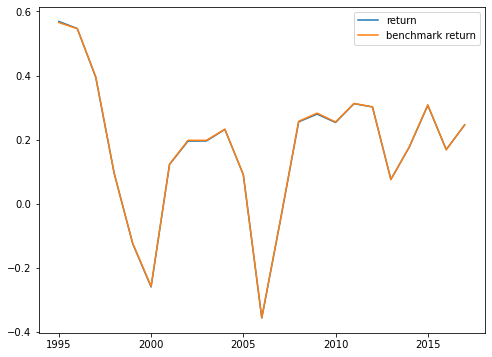

In [86]:
plt.figure(figsize=(8,6))
plt.plot(backtest_3_year['year'],backtest_3_year[['return','benchmark return']])
plt.legend(['return','benchmark return'])
#plt.savefig('backtest_3_year_1.png')

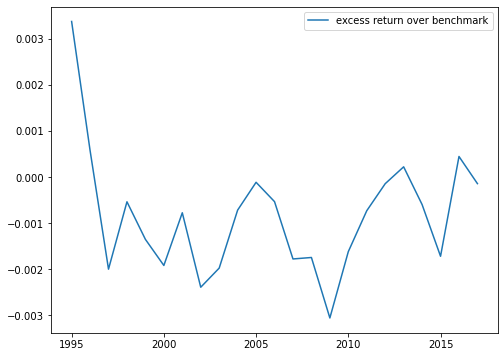

In [87]:
plt.figure(figsize=(8,6))
plt.plot(backtest_3_year['year'],backtest_3_year['excess return over benchmark'])
plt.legend(['excess return over benchmark'])
#plt.savefig('backtest_3_year_2.png')

### Five years
* weekly
* 28 days MA
* ali function

In [100]:
backtest_5_year = pd.DataFrame(columns=['year','return','benchmark return'])
for i in range(1995,2016,1):
    # using suggested parameters
    start_date=f'{i}-01-01'
    input_file = 'SPY.csv'
    inv_period = 'weekly'
    time_length = 5
    ma_period = 28
    function='ali'
    min_rate=0
    max_rate=2
    aip = AIP(input_file,start_date,inv_period,time_length, ma_period, function,min_rate,max_rate)
    aip_ret = aip.fit()
    
    # benchmark return 
    inv_period = 'monthly'
    time_length = 5
    function = 'null'
    aip = AIP(input_file, start_date, inv_period, time_length, ma_period, function, min_rate, max_rate)
    bench_ret = aip.fit()
    backtest_5_year=backtest_5_year.append({'year':i,
                                            'return':aip_ret,
                                            'benchmark return':bench_ret},ignore_index=True)
#backtest_5_year.to_excel('backtest_5_year.xlsx')

In [103]:
backtest_5_year['excess return over benchmark']=backtest_5_year['return']-backtest_5_year['benchmark return']

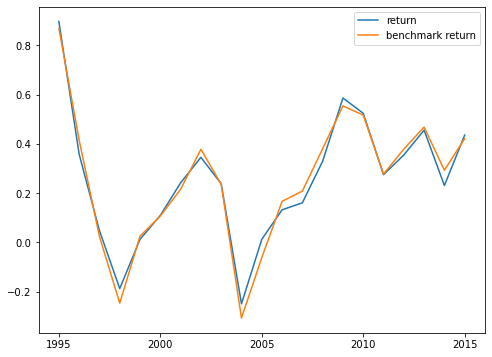

In [108]:
plt.figure(figsize=(8,6))
plt.plot(backtest_5_year['year'],backtest_5_year[['return','benchmark return']])
plt.xticks(ticks=[1995,2000,2005,2010,2015], labels=['1995','2000','2005','2010','2015'])
plt.legend(['return','benchmark return'])
#plt.savefig('backtest_5_year_1.png')

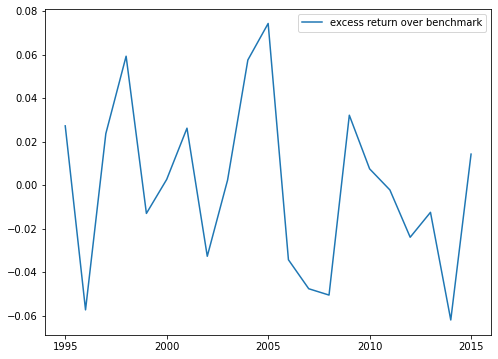

In [109]:
plt.figure(figsize=(8,6))
plt.plot(backtest_5_year['year'],backtest_5_year['excess return over benchmark'])
plt.xticks(ticks=[1995,2000,2005,2010,2015], labels=['1995','2000','2005','2010','2015'])
plt.legend(['excess return over benchmark'])
#plt.savefig('backtest_5_year_2.png')

### Ten years
* weekly
* 28 days
* exp function

In [114]:
backtest_10_year = pd.DataFrame(columns=['year','return','benchmark return'])
for i in range(1995,2011,1):
    # using suggested parameters
    start_date=f'{i}-01-01'
    input_file = 'SPY.csv'
    inv_period = 'weekly'
    time_length = 10
    ma_period = 28
    function='exp'
    min_rate=0
    max_rate=2
    aip = AIP(input_file,start_date,inv_period,time_length, ma_period, function,min_rate,max_rate)
    aip_ret = aip.fit()
    
    # benchmark return 
    inv_period = 'monthly'
    time_length = 10
    function = 'null'
    aip = AIP(input_file, start_date, inv_period, time_length, ma_period, function, min_rate, max_rate)
    bench_ret = aip.fit()
    backtest_10_year=backtest_10_year.append({'year':i,
                                            'return':aip_ret,
                                            'benchmark return':bench_ret},ignore_index=True)
#backtest_10_year.to_excel('backtest_10_year.xlsx')

/Users/veraqian/OneDrive - USC Marshall School of Business/Fall 2021/FBE 551 Quant Investing/Group Final Project/FBE final code/AIP.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['quantity'] = data_used['money'] / data_used['Adj Close']


In [115]:
backtest_10_year['excess return over benchmark']=backtest_10_year['return']-backtest_10_year['benchmark return']
backtest_10_year.head()

,year,return,benchmark return,excess return over benchmark
0,1995.0,0.384960,0.389874,-0.004913
1,1996.0,0.351503,0.326466,0.025037
2,1997.0,0.371532,0.406570,-0.035038
3,1998.0,0.299028,0.285165,0.013863
4,1999.0,-0.182813,-0.244539,0.061726


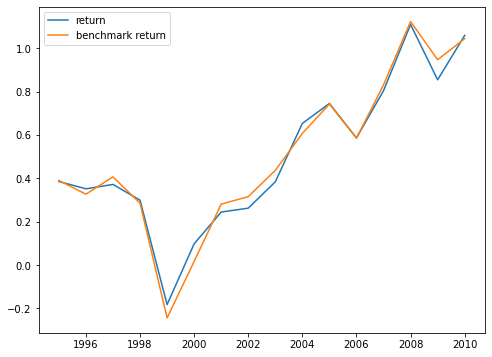

In [116]:
plt.figure(figsize=(8,6))
plt.plot(backtest_10_year['year'],backtest_10_year[['return','benchmark return']])
plt.legend(['return','benchmark return'])
#plt.savefig('backtest_10_year_1.png')

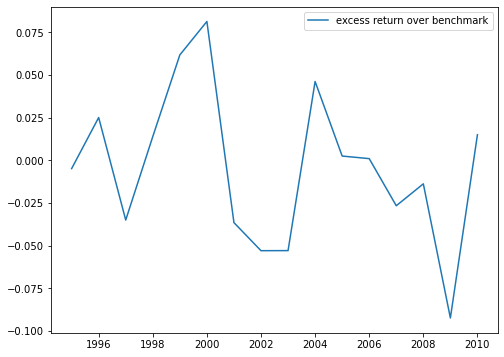

In [117]:
plt.figure(figsize=(8,6))
plt.plot(backtest_10_year['year'],backtest_10_year['excess return over benchmark'])
plt.legend(['excess return over benchmark'])
#plt.savefig('backtest_10_year_2.png')